In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
# Define the device to use (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import os

# Path to the dataset directory
data_dir = '/kaggle/input/cell-images-for-detecting-malaria/cell_images'

# Specify the valid class folders explicitly
valid_classes = ['Parasitized', 'Uninfected']

# Data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [4]:
from torch.utils.data import DataLoader, random_split, Subset
import os
from torchvision import datasets, transforms

# Custom FilteredImageFolder class
class FilteredImageFolder(datasets.ImageFolder):
    def find_classes(self, directory):
        classes = [d for d in os.listdir(directory) if d in valid_classes]
        classes.sort()
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

# Load dataset with filtering
data_dir = '/kaggle/input/cell-images-for-detecting-malaria/cell_images'  # Replace with your dataset path
dataset = FilteredImageFolder(data_dir, transform=transform)

# Verify classes
print(f"Classes: {dataset.classes}")  # Should print: ['Parasitized', 'Uninfected']

# Separate indices for each class
class_indices = {cls: [] for cls in valid_classes}
for idx, (_, label) in enumerate(dataset):
    class_name = dataset.classes[label]
    class_indices[class_name].append(idx)

# Take 2500 samples from each class
subset_indices = class_indices['Parasitized'][:2500] + class_indices['Uninfected'][:2500]

# Create a subset with balanced classes
subset_dataset = Subset(dataset, subset_indices)

# Split into train and test sets
train_size = 4000
test_size = 1000
train_dataset, test_dataset = random_split(subset_dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check dataset sizes
print(f"Train size: {len(train_dataset)}")  # Should print: 4000
print(f"Test size: {len(test_dataset)}")    # Should print: 1000


Classes: ['Parasitized', 'Uninfected']
Train size: 4000
Test size: 1000


In [5]:
next(iter(train_loader))

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0

In [6]:
class MalariaCNN(nn.Module):
    def __init__(self):
        super(MalariaCNN, self).__init__()
        self.conv_layer = nn.Sequential(
            # Conv Layer 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Conv Layer 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Conv Layer 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Conv Layer 4
            #nn.Conv2d(128, 256, kernel_size=3, padding=1),
            #nn.BatchNorm2d(256),
            #nn.ReLU(),
            #nn.MaxPool2d(2)
        )
        
        self.fc_layer = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128 * 8 * 8 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 2)  # 2 classes: Parasitized and Uninfected
        )
        
    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layer(x)
        return x

In [7]:
# Initialize the model
model = MalariaCNN().to(device)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [8]:
from tqdm import tqdm

def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()  # Set model to training mode
    for epoch in range(num_epochs):
        running_loss = 0.0
        # Wrap the train_loader with tqdm to display a progress bar
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

In [9]:
def evaluate_model(model, test_loader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get the class with highest score
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

In [10]:
# Number of epochs
num_epochs = 4

# Train the model
train_model(model, train_loader, criterion, optimizer, num_epochs)

# Evaluate the model
evaluate_model(model, test_loader)

Epoch 1/4: 100%|██████████| 125/125 [01:57<00:00,  1.06it/s]


Epoch [1/4], Loss: 0.6130


Epoch 2/4: 100%|██████████| 125/125 [01:56<00:00,  1.07it/s]


Epoch [2/4], Loss: 0.4323


Epoch 3/4: 100%|██████████| 125/125 [01:56<00:00,  1.08it/s]


Epoch [3/4], Loss: 0.3046


Epoch 4/4: 100%|██████████| 125/125 [01:55<00:00,  1.08it/s]


Epoch [4/4], Loss: 0.2160
Test Accuracy: 91.80%


In [11]:
a = model

In [12]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

def evaluate_model_detailed(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute metrics
    cm = confusion_matrix(all_labels, all_preds)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='binary', pos_label=1)
    recall = recall_score(all_labels, all_preds, average='binary', pos_label=1)
    f1 = f1_score(all_labels, all_preds, average='binary', pos_label=1)
    
    # Sensitivity (Recall for positive class)
    sensitivity = recall
    # Specificity (Recall for negative class)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)

    print("Confusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=['Parasitized', 'Uninfected']))

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall (Sensitivity): {sensitivity:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"F1 Score: {f1:.2f}")

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Parasitized', 'Uninfected'], yticklabels=['Parasitized', 'Uninfected'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Plot metrics
    metrics = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall (Sensitivity)": sensitivity,
        "Specificity": specificity,
        "F1 Score": f1
    }
    
    plt.figure(figsize=(10, 6))
    plt.bar(metrics.keys(), metrics.values(), color='skyblue')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.title('Evaluation Metrics')
    plt.show()


Confusion Matrix:
[[448  56]
 [ 26 470]]

Classification Report:
              precision    recall  f1-score   support

 Parasitized       0.95      0.89      0.92       504
  Uninfected       0.89      0.95      0.92       496

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000

Accuracy: 0.92
Precision: 0.89
Recall (Sensitivity): 0.95
Specificity: 0.89
F1 Score: 0.92


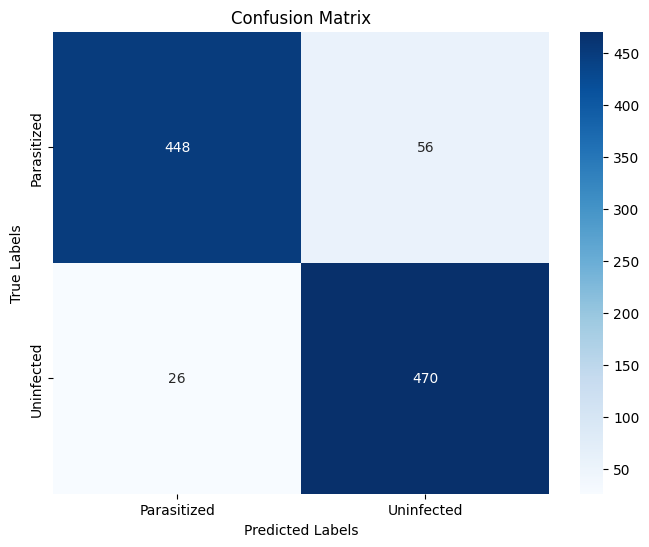

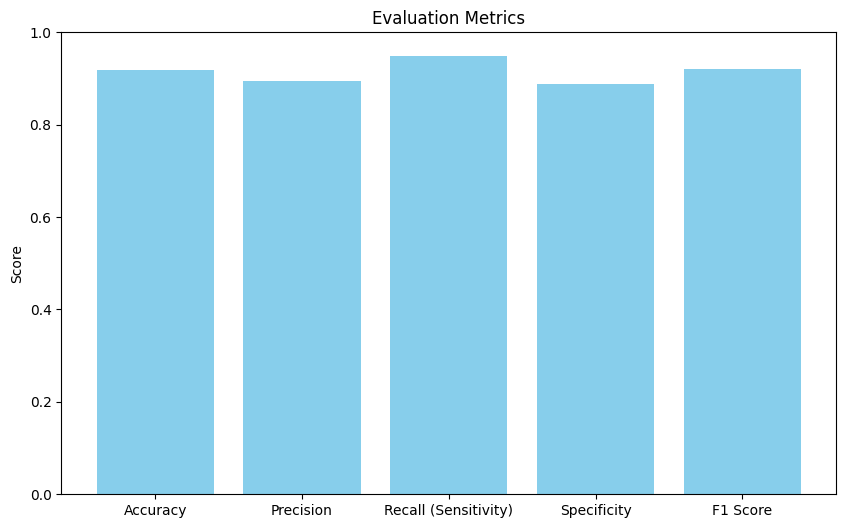

In [13]:
evaluate_model_detailed(model,test_loader)